In [ ]:
# TODO: Train a new model in a new branch

# Evaluation of a Cookie product! (not seen by training)

## Imports

In [1]:
import pandas as pd

from src.features.feature_utils import (
    stem_list,
    process_base_ingredients,
    get_dim_reduction_from_simplification,
    get_entity_simplification_for_feature,
    REGEX_PATTERN,
    RANDOM_SEED,
)
from src.features.feature_information import (
    categs_dict,
    flavor_df_columns_defined
)
from src.data.utils import (
    get_general_path,
    join_paths,
    read_data,
    read_pickle_with_pandas,
    make_desired_folder,
    check_if_filepath_exists,
    save_as_csv,
    save_as_parquet,
    save_as_pickle,
    concat_dataframes_from_list,
)
from src.features.build_features import (
    get_usda_foods,
    get_edamam_flavor_db, 
    get_base_ingredients, 
    process_usda_ingredients, 
    get_list_of_usda_ingredients,
    get_sample_for_categories,
    get_entity_traits,
    compute_flavor_entity_reduction, 
    get_entity_features, 
    get_features_vector_wo_download,
    feature_generation, 
)
from src.models.model_utils import (
    get_model,
    predict
)
from src.visualization.visualization_utils import (
    evaluate_metric,
    plot_histogram,
    plot_proportion_of_similarity_in_bins
)
from sklearn.metrics import roc_auc_score, average_precision_score

## Constants

In [2]:
EDAMAM_FLAVOR_DB = "data/raw/edamam_flavor_dbs_nutrients.pkl"
USDA_FOOD_DB = "data/raw/branded_food.csv"
USDA_SEARCHABLE_DATA = "all_branded_foods_usda_searchable.csv"
INTERIM_DATA_PATH = "data/interim"
AVAILABLE_INGREDIENTS_PATH = "available_ingredients.pkl"
USDA_INGREDIENTS_LIST_PATH = "usda_ingredients.pkl"
SAMPLES_PATH = "samples.pkl"
SAMPLE_FEATURES_PATH = "sample_features.parquet"
SAMPLE_TARGET_PATH = "sample_target.parquet"

ENTITY_NUTRITION_FACTS_PATH = "enf.pkl"
ENTITY_FLAVOR_PROFILE_PATH = "efp.pkl"
ENTITY_FUNCTIONAL_GROUP_PATH = "efg.pkl"
ENTITY_FLAVOR_MOLECULES_PATH = "efm.pkl"


## Read Data

In [3]:
    general_path = get_general_path()
    interim_path = join_paths(general_path, INTERIM_DATA_PATH)
    base_ingredients_path = join_paths(
        interim_path, AVAILABLE_INGREDIENTS_PATH
    )

In [4]:
    usda_foods = get_usda_foods()

/mnt/c/Users/dhdzm/Documents/projects/ingeineria_en_alimentos/ingenieria_en_alimentos/ai_in_food/src/data/utils.py:39: DtypeWarning: Columns (2,3,4,6,9,12,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path, index_col=0, **additional_kwargs)


In [5]:
    searchable_usda_foods = process_usda_ingredients(usda_foods)

Executing process_usda_ingredients function.
No need to process... File exists at: /mnt/c/Users/dhdzm/Documents/projects/ingeineria_en_alimentos/ingenieria_en_alimentos/ai_in_food/src/data/../../data/interim/all_branded_foods_usda_searchable.csv


In [6]:
unique_branded_food_categs = searchable_usda_foods.branded_food_category.value_counts()
# See cookies
unique_branded_food_categs[unique_branded_food_categs.index.str.contains("Cookie")]

branded_food_category
Cookies & Biscuits                 53542
Cake, Cookie & Cupcake Mixes       14704
Biscuits/Cookies                    7727
Biscuits/Cookies (Shelf Stable)     1048
Biscuits/Cookies (Frozen)              3
Name: count, dtype: int64

In [7]:
# New categs_dict for test
categs_dict = {
    'Cookies & Biscuits': 'cookies',
    'Biscuits/Cookies': 'cookies',
    'Biscuits/Cookies (Shelf Stable)': 'cookies',
    'Cheese': 'cheese',
    'Cheese - Block': 'cheese',
    'Cheese/Cheese Substitutes': 'cheese',
    'Cheese - Speciality': 'cheese',
    'Breads & Buns': 'bread',
    # 'Dried Breads (Shelf Stable)': 'bread',
    'Bread': 'bread',
    'Bread (Frozen)': 'bread',
    'Bread (Shelf Stable)': 'bread',
    'Frozen Bread & Dough': 'bread',
    'Yogurt': 'yogurt',
    'Yogurt/Yogurt Substitutes': 'yogurt',
    'Yogurt (Perishable)': 'yogurt',
    'Yogurt/Yogurt Substitutes (Perishable)': 'yogurt',
    'Milk': 'milk',
    'Plant Based Milk': 'milk',
    'Milk/Milk Substitutes': 'milk',
    'Canned Vegetables': 'vegetable',
    'Frozen Vegetables': 'vegetable',
    'Vegetables  Unprepared/Unprocessed (Frozen)': 'vegetable',
    'Vegetables': 'vegetable',
    # 'Pepperoni, Salami & Cold Cuts': 'meat',
    'Sausages, Hotdogs & Brats': 'meat',
    # 'Bacon, Sausages & Ribs': 'meat',
    'Meat/Poultry/Other Animals  Unprepared/Unprocessed': 'meat',
    'Canned Meat': 'meat',
    'Other Meats': 'meat',
    'Other Frozen Meats': 'meat',
    # 'Poultry, Chicken & Turkey': 'meat',
    # 'Frozen Poultry, Chicken & Turkey': 'meat',
    'Vegetarian Frozen Meats': 'meat',
    'Meat/Poultry/Other Animals – Unprepared/Unprocessed': 'meat',
    'Chicken - Unprepared/Unprocessed': 'meat',
    'Meat Substitutes': 'meat',
    'Frozen Meat': 'meat',
    'Salami / Cured Meat': 'meat',
    'Fresh Meat': 'meat',
    'Vegetable & Cooking Oils': 'oil',
    'Oils Edible': 'oil',
    'Oils Edible - Vegetable or Plant (Shelf Stable)': 'oil',
    'Fruit': 'fruit',
    'Canned Fruit': 'fruit',
    'Frozen Fruit': 'fruit',
    'Frozen Fruit & Fruit Juice Concentrates': 'fruit',
    'Fruits  Unprepared/Unprocessed (Frozen)': 'fruit',
    'Frozen Fish & Seafood': 'seafood',
    'Frozen Fish/Seafood': 'seafood',
    'Fish  Unprepared/Unprocessed': 'seafood',
    'Fish – Unprepared/Unprocessed': 'seafood',
    'Canned Seafood': 'seafood',
    'Shellfish Unprepared/Unprocessed': 'seafood',
    'Honey': 'honey',
    'Eggs & Egg Substitutes': 'egg',
    'Eggs/Eggs Substitutes': 'egg',
    'Eggs Products/Substitutes': 'egg',
    'Eggs': 'egg',
    # 'Coffee': 'coffee',
    # 'Coffee/Tea/Substitutes': 'coffee',
    'Butter/Butter Substitutes': 'butter',
    'Butter & Spread': 'butter',
}

In [8]:
    edamam_flavor_db = get_edamam_flavor_db()
    base_ingredients = process_base_ingredients(get_base_ingredients())

In [9]:
usda_ingredients = get_list_of_usda_ingredients(
        base_ingredients=base_ingredients,
        usda_foods=searchable_usda_foods,
    )

Executing get_list_of_usda_ingredients function.
No need to process... File exists at: /mnt/c/Users/dhdzm/Documents/projects/ingeineria_en_alimentos/ingenieria_en_alimentos/ai_in_food/src/data/../../data/interim/usda_ingredients.pkl


## Process data

In [10]:
usda_ingredients["filtered_category"] = usda_ingredients.category.map(categs_dict)#.filtered_category.value_counts()

In [11]:
usda_ingredients.filtered_category.value_counts()

filtered_category
cheese       81763
cookies      62301
bread        55682
vegetable    41200
yogurt       39301
meat         37759
milk         30655
fruit        26359
seafood      22777
oil          17469
butter        8393
honey         5008
egg           2982
Name: count, dtype: int64

In [12]:
    unique_categories = list(set(categs_dict.values()))
    unique_categories

['yogurt',
 'cheese',
 'seafood',
 'meat',
 'cookies',
 'fruit',
 'egg',
 'oil',
 'bread',
 'honey',
 'milk',
 'vegetable',
 'butter']

In [13]:
def get_sample_for_categories(data_set, size=150):
    information_samples = []
    unique_categories = list(set(categs_dict.values()))
    print(unique_categories, 'hello')
    for categ in unique_categories:
        print(categ)
        subcateg_df = data_set[data_set.filtered_category == categ]
        subcategs = subcateg_df.category.unique()
        print(subcategs)
        for subcateg in subcategs:
            print(f"Getting sample for category {categ} "
                  f"in the subcategory {subcateg}")
            subcateg_condition = data_set.category == subcateg
            ingredients_condition = data_set.flavor_ingredients_count != 1
            try:
                sample_df = data_set[
                    ((subcateg_condition) & (ingredients_condition))
                ].sample(size, replace=True, random_state=RANDOM_SEED)
            except:
                sample_df = data_set[
                    subcateg_condition
                ].sample(size, replace=True, random_state=RANDOM_SEED)
            final_sample = sample_df\
                .reset_index()\
                .drop_duplicates('fdc_id')\
                .set_index('fdc_id')
            information_samples.append(final_sample)
    all_samples_df = concat_dataframes_from_list(information_samples)
    all_samples_df['str_flavor_ingredients'] = all_samples_df.\
        flavor_ingredients.apply(sorted).astype('str')
    return all_samples_df

samples = get_sample_for_categories(usda_ingredients)

['yogurt', 'cheese', 'seafood', 'meat', 'cookies', 'fruit', 'egg', 'oil', 'bread', 'honey', 'milk', 'vegetable', 'butter'] hello
yogurt
['Yogurt/Yogurt Substitutes (Perishable)' 'Yogurt'
 'Yogurt/Yogurt Substitutes' 'Yogurt (Perishable)']
Getting sample for category yogurt in the subcategory Yogurt/Yogurt Substitutes (Perishable)
Getting sample for category yogurt in the subcategory Yogurt
Getting sample for category yogurt in the subcategory Yogurt/Yogurt Substitutes
Getting sample for category yogurt in the subcategory Yogurt (Perishable)
cheese
['Cheese' 'Cheese/Cheese Substitutes' 'Cheese - Block']
Getting sample for category cheese in the subcategory Cheese
Getting sample for category cheese in the subcategory Cheese/Cheese Substitutes
Getting sample for category cheese in the subcategory Cheese - Block
seafood
['Frozen Fish & Seafood' 'Canned Seafood'
 'Shellfish Unprepared/Unprocessed' 'Fish  Unprepared/Unprocessed'
 'Fish – Unprepared/Unprocessed' 'Frozen Fish/Seafood']
Getting

In [14]:
efm, efp, efg, enf = get_entity_features()

In [15]:
features = samples.flavor_ingredients.apply(get_features_vector_wo_download, efm=efm, efp=efp, efg=efg, enf=enf)
target = samples[['filtered_category']]

In [16]:
cookies = target[target.filtered_category=="cookies"].reset_index()
cookies['fdc_id2'] = [target.index.to_list()]*cookies.shape[0]

In [17]:
all_cookies = cookies.explode('fdc_id2').merge(target.reset_index(), left_on='fdc_id2', right_on='fdc_id')

In [18]:
all_cookies.loc[all_cookies.filtered_category_x == all_cookies.filtered_category_y, 'similarity'] = 1
all_cookies.loc[all_cookies.filtered_category_x != all_cookies.filtered_category_y, 'similarity'] = 0

In [19]:
all_cookies.similarity.mean()

0.08637873754152824

In [20]:
simplified_cookies = all_cookies.drop(['filtered_category_x', 'filtered_category_y', 'fdc_id2'], axis=1)

In [21]:
simplified_cookies_with_features = simplified_cookies.merge(
    features.reset_index().rename(columns={'fdc_id': 'fdc_id_x'}),
    on='fdc_id_x', how='left',
).merge(
    features.reset_index().rename(columns={'fdc_id': 'fdc_id_y'}),
    on='fdc_id_y', how='left',
)

In [22]:
x_cookies = simplified_cookies_with_features.drop(['similarity', 'fdc_id_x', 'fdc_id_y'], axis=1)
y_cookies = simplified_cookies_with_features[['similarity']]

In [23]:
model = get_model()

In [24]:
pred_cookies = predict(model, x_cookies)

## Results

In [25]:
evaluate_metric(
        y_true=y_cookies,
        y_pred=pred_cookies,
        metric=roc_auc_score,
        metric_name='ROC_AUC',
)
evaluate_metric(
        y_true=y_cookies,
        y_pred=pred_cookies,
        metric=average_precision_score,
        metric_name='Average Precision',
    )

The ROC_AUC score is: 0.8000208924561266
The Average Precision score is: 0.18075755063076224


0.18075755063076224

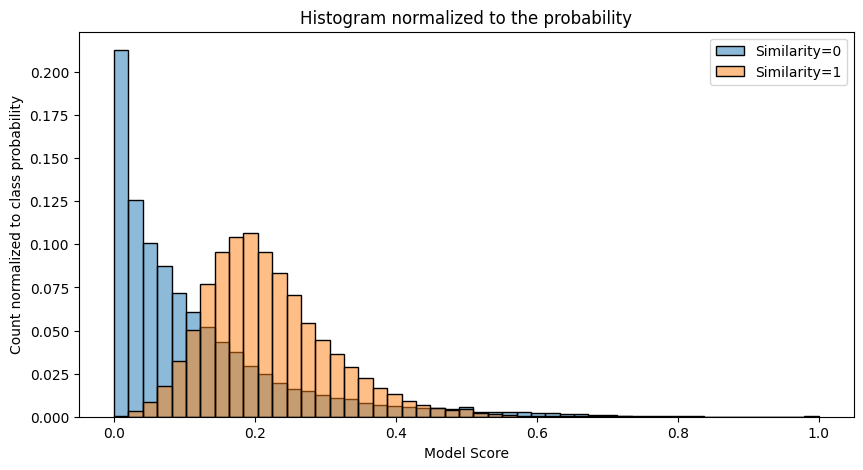

In [28]:
plot_histogram(
    y_true=y_cookies.rename(columns={'similarity': 'similar'}),
    y_pred=pred_cookies,
    fig_name='',
    save=False,
)

## Conclusions:
En conclusión, existe una separabilidad respecto a la similitud de dos conjuntos:
1. La similitud entre galletas y otros productos que no son galletas.
2. La similitud entre galletas y galletas que sí son galletas. 

Por la distinta similitud en la distribución que se encuentra con este alimento no visto para el entrenamiento. Se puede intuir que el modelo está logrando identificar algo. Sin embargo para términos prácticos, la distribución está muy cargada hacia la izquierda por lo que encontrar resultados con esto es virtualmente imposible. 

Se recomienda re-entrenar el modelo, ahora con galletas para que entienda qué es este producto como tal y tener mejores resultados. Después ya se puede comparar. 